In [ ]:
import time

# Start the timer
start_time = time.time()
from queue import PriorityQueue
from collections import defaultdict

start = 'A'
end = 'D'
avoid_node = 'C'

# The graph is defined as a dictionary where each key represents a node and its value is another dictionary containing the neighboring nodes and their respective weights.
graph = {
  'A': {'B': 2, 'C': 3},
  'B': {'A': 2, 'D': 4},
  'C': {'A': 3, 'D': 1},
  'D': {'B': 4, 'C': 1},
}

def kruskal_mst_with_removed_node(graph, removed_node=avoid_node):
    # Initialize variables
    mst = []
    edges = PriorityQueue()
    parent = {}

    # Define a function to find the root of a node in the disjoint set
    def find_root(node):
        while parent[node] != node:
            parent[node] = parent[parent[node]]
            node = parent[node]
        return node

    # Initialize the parent dictionary and add all edges to the priority queue
    for node in graph:
        parent[node] = node
        for neighbor, weight in graph[node].items():
            if node != removed_node and neighbor != removed_node: # skip edge with removed node
                edges.put((weight, node, neighbor))

    # Loop through all edges and add them to the MST if they don't create a cycle
    while not edges.empty():
        weight, u, v = edges.get()
        root_u = find_root(u)
        root_v = find_root(v)
        if root_u != root_v:
            mst.append((u, v, weight))
            parent[root_u] = root_v

    # Sort the MST based on the order of the nodes in the edge tuple
    mst.sort(key=lambda x: (graph[x[0]][x[1]], x[0], x[1]))

    return mst

import heapq

def dijkstra_shortest_path(graph, start, end, removed_node=avoid_node):
    distances = {node: float('inf') for node in graph}
    distances[start] = 0
    queue = [(0, start)]
    prev_nodes = {node: None for node in graph}

    while queue:
        current_distance, current_node = heapq.heappop(queue)

        # Skip nodes that have been removed from the graph
        if current_node == removed_node:
            continue

        if current_distance > distances[current_node]:
            continue

        for neighbor, weight in graph[current_node].items():
            if neighbor == removed_node:
                continue
            distance = current_distance + weight
            if distance < distances[neighbor]:
                distances[neighbor] = distance
                prev_nodes[neighbor] = current_node
                heapq.heappush(queue, (distance, neighbor))

    path = []
    node = end
    while node is not None:
        path.append(node)
        node = prev_nodes[node]

    path.reverse()

    return path if distances[end] != float('inf') else None


# Define a function to find an alternate route for a delayed train or closed track
def find_alternate_route(mst, origin, destination, closed_track, heuristic='shortest_distance'):
    # Initialize variables
    edges = PriorityQueue()
    path = []
    visited = set()
    stack = [origin]
    distances = {node: float('inf') for node in graph}  # distance from origin to each node
    distances[origin] = 0
    time = {node: float('inf') for node in graph}  # time from origin to each node
    time[origin] = 0
    parent = {}
    
    # Define a function to find the root of a node in the disjoint set
    def find_root(node):
        while parent[node] != node:
            parent[node] = parent[parent[node]]
            node = parent[node]
        return node

    # Initialize the parent dictionary and add all edges to the priority queue
    for node in graph:
        parent[node] = node
        for neighbor, weight in graph[node].items():
            edges.put((weight, node, neighbor))
    
    # Loop through all edges and add them to the MST if they don't create a cycle
    while not edges.empty():
        weight, u, v = edges.get()
        root_u = find_root(u)
        root_v = find_root(v)
        if root_u != root_v:
            mst.append((u, v, weight))
            parent[root_u] = root_v
    
    # Sort the MST based on the order of the nodes in the edge tuple
    mst.sort(key=lambda x: (graph[x[0]][x[1]], x[0], x[1]))
    
    # This function performs a depth-first search on a graph to find a path from a starting node to a destination node. It uses a minimum spanning tree (mst) to traverse the graph.
    def dfs(node):
        
        visited.add(node)
        path.append(node)
        if node == destination:
            return True
        for u, v, weight in mst:
            if u == node and v not in visited and v != closed_track:
                if heuristic == 'shortest_distance':
                    if distances[node] + weight < distances[v]:
                        distances[v] = distances[node] + weight
                        parent[v] = node
                    if dfs(v):
                        return True
                elif heuristic == 'shortest_time':
                    if time[node] + weight < time[v]:
                        time[v] = time[node] + weight
                        parent[v] = node
                    if dfs(v):
                        return True
        # True if the destination node is found, False otherwise.
        path.pop()
        return False
    
    # Call the DFS function to find the path
    dfs(origin)
    
    # Check if the path is valid
    if not path:
        print("No valid path found.")
    elif path[-1] != destination:
        print("No valid path found.")
    else:
        # Given a path and a destination, print out the alternate route if it exists.
        print("Alternate Route:")
        for i in range(len(path)-1):
            u, v = path[i], path[i+1]
            for edge in mst:
                if edge[0] == u and edge[1] == v:
                    print(f"{u} - {v} : {edge[2]}")
                    break

# Find the minimum spanning tree using Kruskal's algorithm
mst = kruskal_mst_with_removed_node(graph,avoid_node)
print("Minimum Spanning Tree:")
for edge in mst:
    print(f"{edge[0]} - {edge[1]} : {edge[2]}")

shortest_path = dijkstra_shortest_path(graph, start, end, avoid_node)
if shortest_path is not None:
    print(f"Shortest path from {start} to {end} with {avoid_node} removed: {' -> '.join(shortest_path)}")
else:
    print(f"No path found from {start} to {end} with {avoid_node} removed.")

# Find an alternate route using DFS
alternate_route = find_alternate_route(mst, start, end, closed_track=avoid_node, heuristic='shortest_distance')

# Define a function to find all paths in a graph that do not contain a particular node
def find_paths(graph, start, end, avoid_node):
    paths = []
    visited = set()

    # Define a helper function to recursively find paths
    def dfs(node, path):
        if node == end:
            paths.append(path)
        else:
            visited.add(node)
            for neighbor in graph[node]:
                if neighbor not in visited and neighbor != avoid_node:
                    dfs(neighbor, path + [neighbor])
            visited.remove(node)

    # Call the helper function to find all paths from the start node to the end node
    dfs(start, [start])
    return paths
paths = find_paths(graph, start, end, avoid_node)
for path in paths:
    print(path)


# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"The code block took {elapsed_time} seconds to run.")

Minimum Spanning Tree:
A - B : 2
B - D : 4
Shortest path from A to D with C removed: A -> B -> D
Alternate Route:
A - B : 2
B - D : 4
['A', 'B', 'D']
The code block took 0.005278587341308594 seconds to run.


In [ ]:
import time

# Start the timer
start_time = time.time()

import random
import heapq

start = 'A'
end = 'D'
avoidnode = 'E'

graph = {
  'A': {'B': 2, 'C': 3},
  'B': {'A': 2, 'D': 4, 'E': 3},
  'C': {'A': 3, 'D': 1},
  'D': {'B': 4, 'C': 1},
  'E': {'B': 3}
}

 
# function to generate random edges
def random_edges(graph):
    edges = []
    for u in graph:
        for v in graph[u]:
            edges.append((u, v, graph[u][v]))
    random.shuffle(edges)
    return edges

# function to find parent of a node
def find(parent, node):
    if parent[node] == node:
        return node
    parent[node] = find(parent, parent[node])
    return parent[node]

# function to run Kruskal's algorithm with randomized edge selection
def kruskals_randomized_algorithm_without_node_r(graph, avoidnode):
    parent = {}
    rank = {}
    for node in graph:
        parent[node] = node
        rank[node] = 0
    edges = random_edges(graph)
    mst = []
    for edge in edges:
        u, v, weight = edge
        if u == avoidnode or v == avoidnode:
            continue
        parent_u = find(parent, u)
        parent_v = find(parent, v)
        if parent_u != parent_v:
            mst.append(edge)
            if rank[parent_u] > rank[parent_v]:
                parent[parent_v] = parent_u
            elif rank[parent_u] < rank[parent_v]:
                parent[parent_u] = parent_v
            else:
                parent[parent_v] = parent_u
                rank[parent_u] += 1
    return mst



def dijkstras_algorithm_r(graph, start, end,avoidnode):
    if avoidnode is not None:
        # remove the specified node and its edges from the graph
        if avoidnode in graph:
            del graph[avoidnode]
        for node in graph:
            if avoidnode in graph[node]:
                del graph[node][avoidnode]

    queue = []
    distance = {}
    for node in graph:
        distance[node] = float('inf')
    distance[start] = 0
    heapq.heappush(queue, (0, start))
    while queue:
        curr_dist, curr_node = heapq.heappop(queue)
        if curr_node == end:
            return distance[end]
        for neighbor in graph[curr_node]:
            new_dist = curr_dist + graph[curr_node][neighbor]
            if new_dist < distance[neighbor]:
                distance[neighbor] = new_dist
                heapq.heappush(queue, (new_dist, neighbor))

    # add back the removed node and its edges to the graph
    if avoidnode is not None:
        graph[avoidnode] = {}
        for node in graph:
            if avoidnode in graph[node]:
                graph[node][avoidnode] = graph[avoidnode][node]

    return distance[end]
# function to find alternate paths using Kruskal's algorithm with random node selection
def alternate_paths_r(graph, start, end, avoidnode):
    if avoidnode is not None:
        # remove the specified node and its edges from the graph
        if avoidnode in graph:
            del graph[avoidnode]
        for node in graph:
            if avoidnode in graph[node]:
                del graph[node][avoidnode]

    # find the minimum spanning tree
    mst = kruskals_randomized_algorithm_without_node_r(graph,avoidnode)

    # find alternate paths for each edge in the minimum spanning tree
    alternate_paths = []
    for u, v, weight in mst:
        graph[u].pop(v)
        graph[v].pop(u)
        if dijkstras_algorithm_r(graph, start, end,avoidnode) != float('inf'):
            alternate_paths.append((u, v, weight))
        graph[u][v] = weight
        graph[v][u] = weight

    # add back the removed node and its edges to the graph
    if avoidnode is not None:
        graph[avoidnode] = {}
        for node in graph:
            if avoidnode in graph[node]:
                graph[node][avoidnode] = graph[avoidnode][node]

    return alternate_paths

# example graph
mst = kruskals_randomized_algorithm_without_node_r(graph,avoidnode)
print("Minimum Spanning Tree:")
for edge in mst:
  print(edge)

shortest_path = dijkstras_algorithm_r(graph, start, end,avoidnode)
print("\nShortest Path:")
print(shortest_path)

alternate_paths = alternate_paths_r(graph, start, end, avoidnode)
print("\nAlternate Paths with Node B Removed:")
for path in alternate_paths:
  print(path)

for i in range(1000000):
    pass

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"The code block took {elapsed_time} seconds to run.") 



Minimum Spanning Tree:
('A', 'B', 2)
('A', 'C', 3)
('C', 'D', 1)

Shortest Path:
4

Alternate Paths with Node B Removed:
('C', 'D', 1)
('B', 'A', 2)
('A', 'C', 3)
The code block took 0.05179333686828613 seconds to run.


Alternate Route:
No valid path found.
Alternate Route:
0 - 16 : 1
16 - 99 : 1
No valid path found.


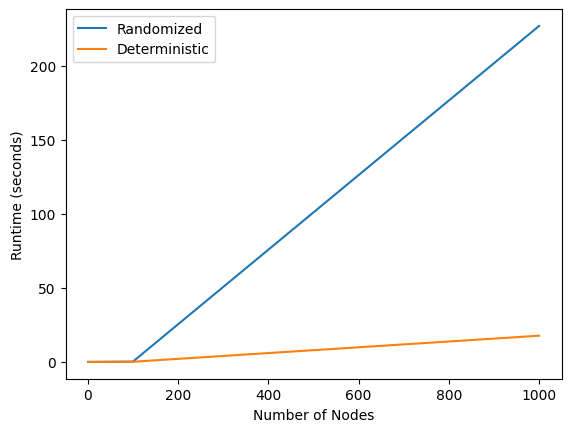

In [ ]:
import time
import random
import matplotlib.pyplot as plt
# The time vs nodes graph for a larger graph
# function to generate random graph with n nodes
def generate_graph(n):
# Generate a graph with n nodes, where each node is connected to every other node
# with a random weight between 1 and 10.
    graph = {}
    for i in range(n):
        node = str(i)
        edges = {}
        for j in range(n):
            if i != j:
                neighbor = str(j)
                weight = random.randint(1, 10)
                edges[neighbor] = weight
        graph[node] = edges
    # Returns a dictionary representing the graph, where each key is a node and the value is a dictionary of its neighbors and their weights.
    return graph

# number of nodes to test
nodes = [1, 10, 100, 1000]

runtimes = []
runtimes_r = []
for n in nodes:
    # Generate random graph
    graph = generate_graph(n)

    # Measure runtime of the code
    start_time = time.time()
    # This code snippet calculates the runtime of two algorithms, Kruskal's Randomized Algorithm and Dijkstra's Algorithm, and stores the results in two separate lists. 
    mst = kruskals_randomized_algorithm_without_node_r(graph,avoidnode)
    shortest_path = dijkstras_algorithm_r(graph, '0', str(n-1),avoidnode)
    alt_paths_list = alternate_paths_r(graph, '0', str(n-1),avoidnode)
    alt_paths = len(alt_paths_list)
    end_time = time.time()
    runtime = end_time - start_time
    runtimes_r.append(runtime)

    start_time = time.time()
    mst = kruskal_mst_with_removed_node(graph)
    alternate_route = find_alternate_route(mst, '0', str(n-1),closed_track=True)
    end_time = time.time()
    runtime = end_time - start_time
    runtimes.append(runtime)

# Ploting the graph
fig, ax = plt.subplots()
ax.plot(nodes, runtimes_r, label='Randomized')
ax.plot(nodes, runtimes, label='Deterministic')
ax.legend()
plt.xlabel('Number of Nodes')
plt.ylabel('Runtime (seconds)')
plt.show()

Alternate Route:
Alternate Route:
0 - 1 : 1
1 - 9 : 1
Alternate Route:
0 - 13 : 1
13 - 16 : 1
16 - 1 : 1
1 - 19 : 1
No valid path found.
No valid path found.
Alternate Route:
0 - 11 : 1
11 - 17 : 1
17 - 27 : 1
27 - 49 : 1
No valid path found.
No valid path found.
No valid path found.
Alternate Route:
0 - 14 : 1
14 - 89 : 1
Alternate Route:
0 - 30 : 1
30 - 99 : 1


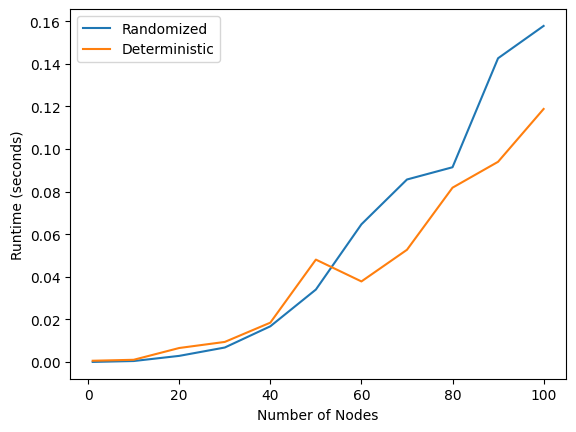

In [ ]:
import time
import random
import matplotlib.pyplot as plt
# The time vs nodes graph for comparing the randomized and deterministic versions of Kruskal's algorithm
# function to generate random graph with n nodes
def generate_graph(n):
    graph = {}
    for i in range(n):
        node = str(i)
        edges = {}
        for j in range(n):
            if i != j:
                neighbor = str(j)
                weight = random.randint(1, 10)
                edges[neighbor] = weight
        graph[node] = edges
    return graph

# number of nodes to test
nodes = [1,10,20,30,40,50,60,70,80,90,100]

runtimes = []
runtimes_r = []
for n in nodes:
    # generate random graph
    graph = generate_graph(n)

    # measure runtime of the code
    start_time = time.time()
    mst = kruskals_randomized_algorithm_without_node_r(graph,avoidnode)
    shortest_path = dijkstras_algorithm_r(graph, '0', str(n-1),avoidnode)
    alt_paths_list = alternate_paths_r(graph, '0', str(n-1),avoidnode)
    alt_paths = len(alt_paths_list)
    end_time = time.time()
    runtime = end_time - start_time
    runtimes_r.append(runtime)

    start_time = time.time()
    mst = kruskal_mst_with_removed_node(graph)
    alternate_route = find_alternate_route(mst, '0', str(n-1),closed_track=True)
    end_time = time.time()
    runtime = end_time - start_time
    runtimes.append(runtime)

# plot the graph
fig, ax = plt.subplots()
ax.plot(nodes, runtimes_r, label='Randomized')
ax.plot(nodes, runtimes, label='Deterministic')
ax.legend()
plt.xlabel('Number of Nodes')
plt.ylabel('Runtime (seconds)')
plt.show()